In [1]:
import pandas as pd
import jieba
import jieba.analyse
import scipy as sp
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
def is_chinese(uchar):         
    if u'\u4e00' <= uchar<=u'\u9fff':
        return True
    else:
        return False
jieba.load_userdict("data/dict.txt")
with open('data/stop.txt', 'rt',encoding="utf-8") as txt:
    stopword = txt.read()
stopword = stopword.split("\n")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\chloe\AppData\Local\Temp\jieba.cache
Loading model cost 1.163 seconds.
Prefix dict has been built succesfully.


In [3]:
news1 = pd.read_csv("data/news1.csv",encoding="utf-8-sig")
news2 = pd.read_csv("data/news2.csv",encoding="utf-8-sig")
news3 = pd.read_csv("data/news3.csv",encoding="utf-8-sig")

In [4]:
#斷詞&tfidf
def keyword(df):
    corpus = []
    for t in list(df.txt):
        cut = list(jieba.cut(t))
        txt = []
        for word in cut:
            save = False
            if word in stopword:
                continue
            for w in word:
                if is_chinese(w) == False:
                    save = False
                    break
                else:
                    save = True
            if save == True:    
                txt.append(word)
        corpus.append(" ".join(txt))
    vectorizer = TfidfVectorizer(min_df=1, stop_words = stopword)
    tfidf = vectorizer.fit_transform(corpus)
    words = vectorizer.get_feature_names()
    
    return tfidf,words
    

In [5]:
#Kmeans分群
LABEL_COLOR_MAP = {0:'tomato', 1: 'lime',2:"dodgerblue",3:"gold",4:"blueviolet",5:"darkcyan",6:"hotpink",7:"sienna",8:"darkgreen",9:"mediumpurple",10:"coral"}
def Newsclustering(n,df,tfidf):
    pca = PCA(n_components=2)
    x = pca.fit_transform(tfidf.toarray())
    kmeans = KMeans(n_clusters =n)
    X_clustered = kmeans.fit_predict(x)
    df["cluster"] = X_clustered
    label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]    
    trace = go.Scatter(
        x = x[:,0],
        y = x[:,1],
        mode = 'markers',
        text=[t+"<br>"+s for t,s in zip(df.time,df.source)],
        hoverinfo = 'text',
        marker={
            'size': 10,
            'opacity': 0.6,
            'color': label_color
        }
    )
    data = [trace]
    return py.iplot(data)

In [6]:
#長條圖
def newsbar(df):
    cluster_df = []
    for n in sorted(df.cluster.unique(),reverse=False):
        cluster_df.append(df[df.cluster==n].source.value_counts(ascending=True).to_frame())
    cluster_merge = pd.concat([cdf for cdf in cluster_df],axis=1,sort=False).fillna(0)
    cluster_merge.columns=["cluster"+str(n) for n in sorted(df.cluster.unique(),reverse=False)]


    data=[]
    n=0
    for col in cluster_merge:    
        t = go.Bar(
        y=cluster_merge.index,
        x=cluster_merge[col],
        name=col,
        orientation = 'h',
        text=[str(int(round(p,2)*100))+"%" for p in cluster_merge[col]/cluster_merge.sum(axis=1)],
        opacity=0.8, 
        marker = dict(
            color = LABEL_COLOR_MAP[n],
            line = dict(
                color = LABEL_COLOR_MAP[n],
                width = 3)
            )
        )
        data.append(t)
        n+=1
    layout = go.Layout(
        barmode='stack',
        title="新聞來源",
        titlefont= {
        "size": 36,
        "family":'Microsoft JhengHei,Courier New, monospace',

      },
         xaxis=dict(
            title='數量',
            titlefont=dict(
                family='Microsoft JhengHei,Courier New, monospace',
                size=18,
                color='black'
            )
        ),
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig)

In [7]:
#文字雲
def wordclound(df,tfidf,words):
    for clu in df.cluster.unique():
        cluster={}
        for i in df[df.cluster==clu].index:
            for j in range(len(words)):
                if tfidf[i,j] > 0.15:
                    if words[j] in cluster:
                        cluster[words[j]] += tfidf[i,j]
                    else:
                        cluster[words[j]] = tfidf[i,j]
        wordcloud = WordCloud(background_color="white",width=2000, height=1000, margin=2,font_path = "msjh.ttc")
        wordcloud.fit_words(cluster)
        plt.rcParams["font.sans-serif"]=["SimHei"]
        plt.figure(figsize=(12,10))
        plt.title("cluster"+str(clu),fontsize=30)
        plt.grid(False)
        plt.imshow(wordcloud)

# 樂陞

In [8]:
N1 = keyword(news1)
Newsclustering(2,news1,N1[0])

In [9]:
newsbar(news1)

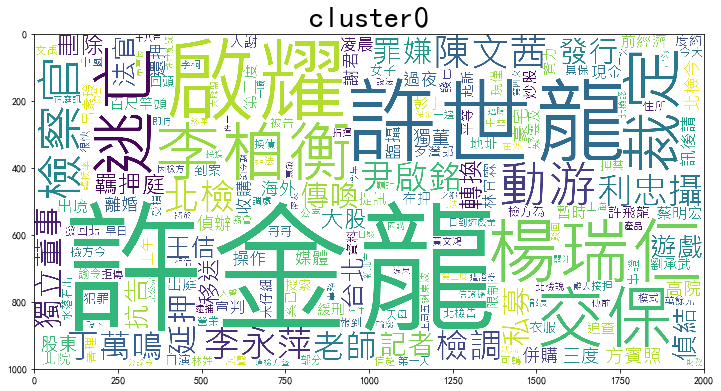

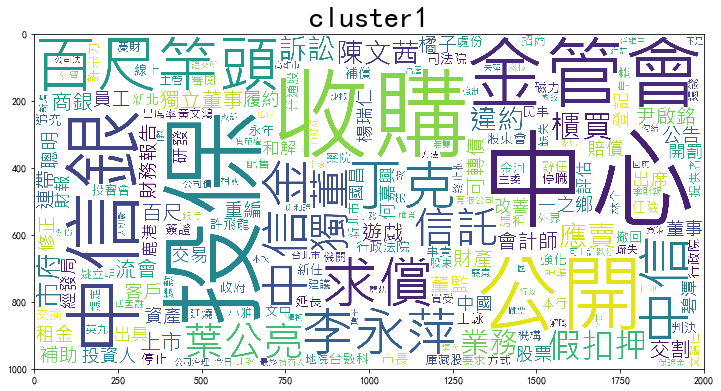

In [10]:
wordclound(news1,N1[0],N1[1])

# 兆豐

In [11]:
N2 = keyword(news2)
Newsclustering(2,news2,N2[0])

In [12]:
newsbar(news2)

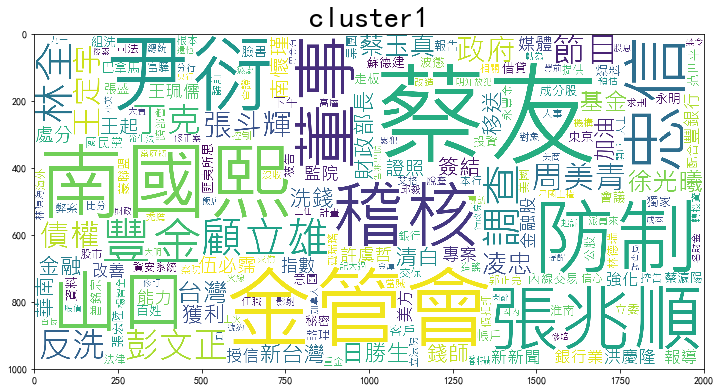

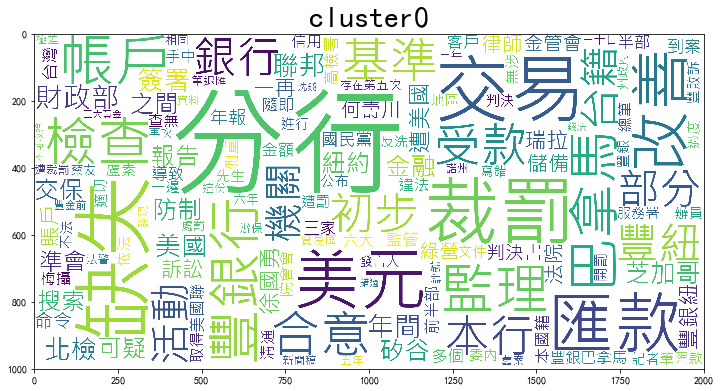

In [13]:
wordclound(news2,N2[0],N2[1])

# 三寶

In [14]:
N3 = keyword(news3)
Newsclustering(2,news3,N3[0])

In [15]:
newsbar(news3)

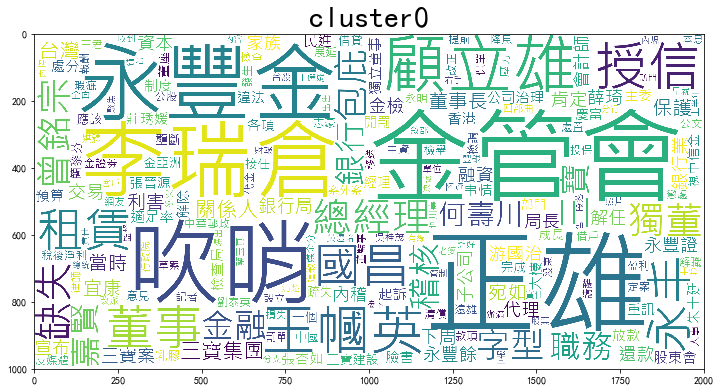

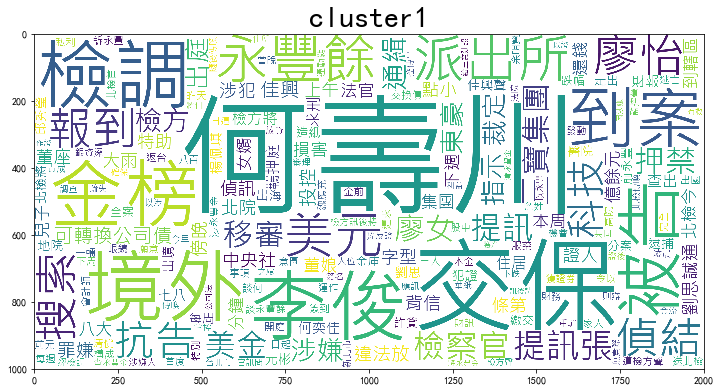

In [16]:
wordclound(news3,N3[0],N3[1])